#future 30 days
#7 days past

https://medium.com/aiskunks/time-series-forecasting-using-deep-learning-ebe383913c5f

# Import necessary libraries 


In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, window, sum, lit, to_date
import matplotlib.pyplot as plt
import pyspark.sql.functions as psf
import pandas as pd
import seaborn as sns
import numpy as np
import keras
import math
import tensorflow as tf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, window, sum, lit
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import pyspark.sql.functions as psf
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings("ignore") 



# Create a spark Session

In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("CA01_Sem_02").config("spark.executor.memory","10g").getOrCreate()
spark

24/03/22 15:06:36 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### Data_Ingestion Module
 To leverage the use of hadoop,  this module was created to read the csv files into a pyspark dataframe and save on hadoop hdfs system

In [3]:

# data_ingestion function: Loads all CSV files in a directory using PySpark and saves them to a specified output path on HDFS.
# Args: 
    # path: Path to the directory containing CSV files  
    # hd_path: Hadoop path on HDFS to save the processed files

def data_ingestion( path, hd_path):
    
    try:
        # Read all files in the directory matching the CSV extension (*.csv)
        df = spark.read.csv(path, header=True, inferSchema = True)

        # Save the DataFrame to Hadoop server - HDFS
        df.write.mode("overwrite").csv(hd_path, header=True)
        print('Data Ingestion Completed')

    except Exception as e:
        print("An error occurred:", e)
    
    
    

# Running the data_ingestion function

In [14]:

# path to directory where the files are
path = "file:///home/hduser/Documents/CA01_Sem_02_MSc_Data_Analytics/*.csv"

# path where the files should be saved on hadoop
hd_path = "/user/hduser/bike_data/"

# Call the processing function
data_ingestion(path, hd_path)


Data Ingestion Completed


### Verifying the data on hadoop

In [5]:
!hdfs dfs -ls /user/hduser/bike_data


Found 11 items
-rw-r--r--   1 hduser supergroup          0 2024-03-22 01:43 /user/hduser/bike_data/_SUCCESS
-rw-r--r--   1 hduser supergroup   96739828 2024-03-22 01:43 /user/hduser/bike_data/part-00000-454d576a-1573-4842-95b4-4f7556e392f8-c000.csv
-rw-r--r--   1 hduser supergroup   93859490 2024-03-22 01:43 /user/hduser/bike_data/part-00001-454d576a-1573-4842-95b4-4f7556e392f8-c000.csv
-rw-r--r--   1 hduser supergroup   93287714 2024-03-22 01:43 /user/hduser/bike_data/part-00002-454d576a-1573-4842-95b4-4f7556e392f8-c000.csv
-rw-r--r--   1 hduser supergroup   89508134 2024-03-22 01:43 /user/hduser/bike_data/part-00003-454d576a-1573-4842-95b4-4f7556e392f8-c000.csv
-rw-r--r--   1 hduser supergroup   86649859 2024-03-22 01:43 /user/hduser/bike_data/part-00004-454d576a-1573-4842-95b4-4f7556e392f8-c000.csv
-rw-r--r--   1 hduser supergroup   86128007 2024-03-22 01:43 /user/hduser/bike_data/part-00005-454d576a-1573-4842-95b4-4f7556e392f8-c000.csv
-rw-r--r--   1 hduser supergroup   78088682 20

# Load data from hadoop

In [41]:

hd_path = "/user/hduser/bike_data/"

try:
   

  # Read the CSV files using the specified path
  df = spark.read.csv(hd_path, header = True, inferSchema = True)

  # Print the first few rows of the DataFrame (optional)
  df.show(2)

   
except Exception as e:
    print("An error occurred:", str(e))


+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+---------+----------+-----------------+------------------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|start_lat| start_lng|          end_lat|           end_lng|member_casual|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+---------+----------+-----------------+------------------+-------------+
|20CAF4CAD9186B1C|  docked_bike|2023-03-26 16:52:35|2023-03-26 17:22:08|Washington & Inde...|           31272|15th St & Constit...|         31321|38.886978|-77.013769|        38.892244|        -77.033234|       casual|
|695D9110D59A0A42| classic_bike|2023-03-28 16:51:30|2023-03-28 17:06:32|      11th & C St SE|           31659|D St & Marylan

In [42]:
df.printSchema()

root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: integer (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: integer (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)



### Checking the shape of the dataframe\


In [43]:
print((df.count(), len(df.columns)))

(4467334, 13)


When it comes to using RNNs for time series forecasting or analysis, the data structure must have some level of consistency, as each row of the dataset represents one trip, only  a new column was created to represent the tripa and only  date and trips were selected from the dataset

In [44]:
trips = df.select("started_at")

In [45]:
trips.show(5)

+-------------------+
|         started_at|
+-------------------+
|2023-03-26 16:52:35|
|2023-03-28 16:51:30|
|2023-03-28 19:25:55|
|2023-03-03 16:33:58|
|2023-03-11 14:31:24|
+-------------------+
only showing top 5 rows



In [46]:
trips = trips.withColumn("started_at",to_date(col("started_at")).alias("date"))

In [47]:
trips.show(5)

+----------+
|started_at|
+----------+
|2023-03-26|
|2023-03-28|
|2023-03-28|
|2023-03-03|
|2023-03-11|
+----------+
only showing top 5 rows



In [48]:
trips = trips.withColumn("trips", lit(1))

In [49]:
trips.show(5)

+----------+-----+
|started_at|trips|
+----------+-----+
|2023-03-26|    1|
|2023-03-28|    1|
|2023-03-28|    1|
|2023-03-03|    1|
|2023-03-11|    1|
+----------+-----+
only showing top 5 rows



In [50]:
trips.printSchema()

root
 |-- started_at: date (nullable = true)
 |-- trips: integer (nullable = false)



In [54]:
#window_spec = window(trips['started_at'], "1 day")
daily_df = trips.groupBy("started_at").agg(sum("trips").alias("total_trips"))


In [56]:
daily_df = daily_df.orderBy("started_at")

In [57]:
daily_df.show(10)

+----------+-----------+
|started_at|total_trips|
+----------+-----------+
|2023-01-01|       6787|
|2023-01-02|       7240|
|2023-01-03|       7559|
|2023-01-04|       7791|
|2023-01-05|       8409|
|2023-01-06|       6719|
|2023-01-07|       7122|
|2023-01-08|       5176|
|2023-01-09|       6520|
|2023-01-10|       7303|
+----------+-----------+
only showing top 10 rows



In [58]:
daily_df.describe().show()

+-------+------------------+
|summary|       total_trips|
+-------+------------------+
|  count|               365|
|   mean|12239.271232876712|
| stddev| 3983.046929307485|
|    min|              2369|
|    max|             20174|
+-------+------------------+



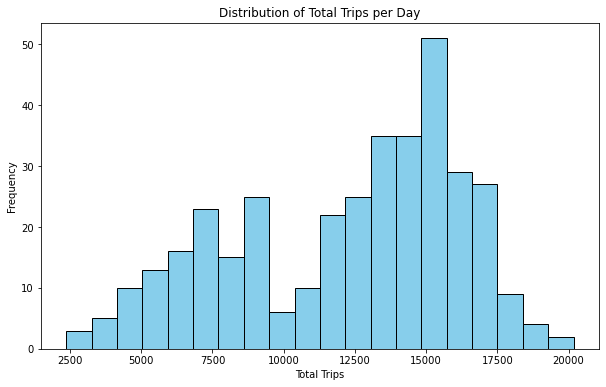

In [59]:
# Converting PySpark DataFrame to Pandas DataFrame
pandas_df = daily_df.toPandas()

# Plotting a histogram
plt.figure(figsize=(10, 6))
plt.hist(pandas_df['total_trips'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Trips per Day')
plt.xlabel('Total Trips')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()


In [10]:
pandas_df = pd.read_csv("pandas_df.csv").reset_index()

In [12]:
pandas_df = pandas_df[["started_at","total_trips"]]


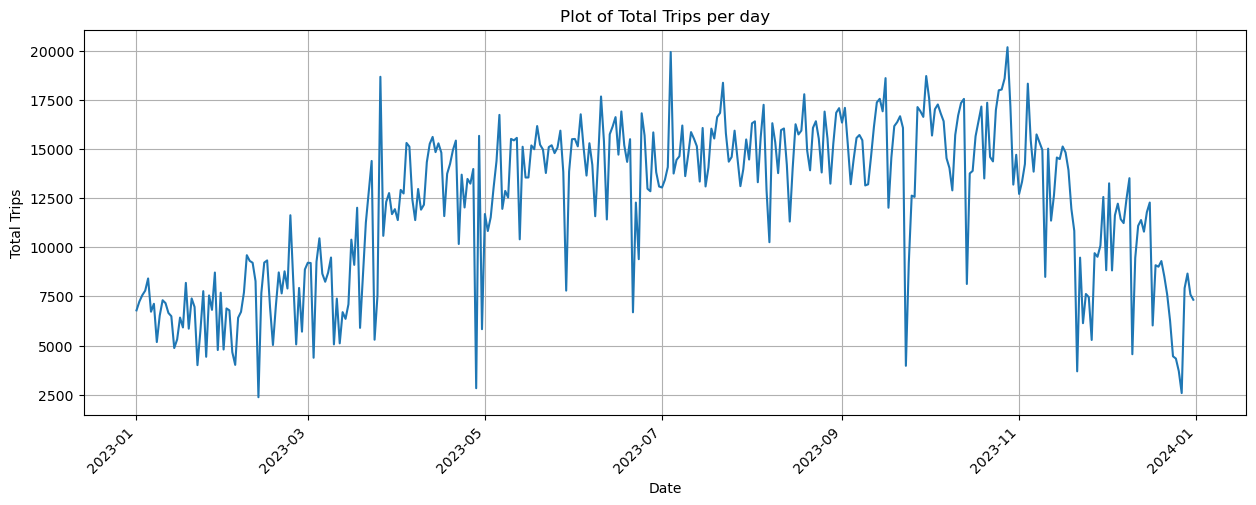

In [46]:

pandas_df['started_at'] = pd.to_datetime(pandas_df['started_at'])

plt.figure(figsize=(15, 5))

plt.plot(pandas_df["started_at"], pandas_df["total_trips"])

plt.xlabel("Date")
plt.ylabel("Total Trips")
plt.title("Plot of Total Trips per day")
plt.xticks(rotation=45, ha='right')
plt.grid(True) 
plt.show()


In [43]:
trips = pandas_df.iloc[:,-1]

In [44]:
type(trips)

pandas.core.series.Series

# LSTM Model Building:



    For building a LSTM model, its important to observe some parameters:
    Input layer: This layer takes the sequence of past trip counts as input. for this project, a window size of past 7 days was chosen to feed into the LSTM.
    LSTM layer: This layer is the core of the model, responsible for learning long-term dependencies in the trip count data. The model will be evaluated with different layers and numbers.
    Output layer: This layer predicts the future trip count. It will be used a single neuron with a linear activation for numerical prediction.
       
    TensorFlow is designed to work primarily with NumPy arrays. Because of this, pandas.core.series will be transform into NumPy arrays.



        The next thing we need to do is to specify our number of timesteps. Timesteps specify how many previous observations should be considered when the recurrent neural network makes a prediction about the current observation.
    We will use 7 (week based) timesteps. This means that for every day that the neural network predicts, it will consider the previous 7 days of trips to determine its output. 


In [154]:
def preprocessing(scaler, look_back):
        
    pandas_df = pd.read_csv("pandas_df.csv")
    trips = pandas_df.iloc[:,-1]
    
   
    # convert to numpy array
    np_trips = trips.to_numpy()
    np_trips = np_trips.astype('float32')
    np_trips = np_trips.reshape(-1,1)


    # convert an array of values into a dataset matrix
    def create_dataset(dataset, look_back):
    	dataX, dataY = [], []
    	for i in range(len(dataset)-look_back-1):
    		a = dataset[i:(i+look_back), 0]
    		dataX.append(a)
    		dataY.append(dataset[i + look_back, 0])
    	return np.array(dataX), np.array(dataY)

    # normalize the dataset
    np_trips = scaler.fit_transform(np_trips)
    
    # split into train and test sets
    train_size = int(len(np_trips) * 0.75)
    test_size = len(np_trips) - train_size
    train, test = np_trips[0:train_size,:], np_trips[train_size:len(np_trips),:]
    
  
   
    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


    
    
    trainX.shape, testX.shape
    return trainX, testX, trainY, testY, np_trips

In [155]:
look_back = 1  # defining the look_back


# Model 01

In [156]:

# create and fit the LSTM network
model1 = Sequential()
model1.add(LSTM(8, input_shape=(1, look_back)))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')
model1.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                  │ (None, 8)              │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329 (1.29 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

In [157]:
# scaler to normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

#call the function processing
trainX, testX , trainY , testY, np_trips = preprocessing(scaler, look_back)


model1.fit(trainX, trainY, epochs=300, batch_size=16, verbose=1)

Epoch 1/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3034
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2571 
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2254 
Epoch 4/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1752 
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1505 
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1119 
Epoch 7/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0843 
Epoch 8/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0725 
Epoch 9/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0578 
Epoch 10/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0478 
Epoch 11/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0398 
Epoch 12/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0315 
Epoch 13/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0311 
Epoch 14/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0300 
Epoch 15/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

In [158]:
# make predictions
trainPredict = model1.predict(trainX)
testPredict = model1.predict(testX)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [159]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [160]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 2682.08 RMSE
Test Score: 2698.48 RMSE


RMSE (Root Mean Squared Error):

    It measures the difference between predicted and actual trip counts.
    Lower RMSE indicates better performance. Ideally, you want the error to be as small as possible.

Training vs Test Score:

    The training score (0.13) is slightly lower than the test score (0.17), which is a good sign. It indicates that the model is not overfitting to the training data and can generalize somewhat well to unseen data (test set).

Interpretation:

    An RMSE of 0.13 on the training data suggests that on average, the model's predictions are off by about 0.13 times the scale of your trip count data.
    The test score of 0.17 indicates a slightly higher average error on unseen data, but it's still relatively low.

Considering the Data Size:

    With a limited dataset size of 365 days, achieving very low RMSE scores might be challenging. The model might not be able to capture all the complex variations in the daily trip counts.

Overall Assessment:

These scores suggest that the LSTM model is capturing some underlying patterns in the trip count data and can make reasonable predictions. However, there's still room for improvement.

In [161]:
#shift train predictions for plotting
trainPredictPlot = np.empty_like(np_trips)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict


# shift test predictions for plotting
testPredictPlot = np.empty_like(np_trips)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(np_trips)-1, :] = testPredict


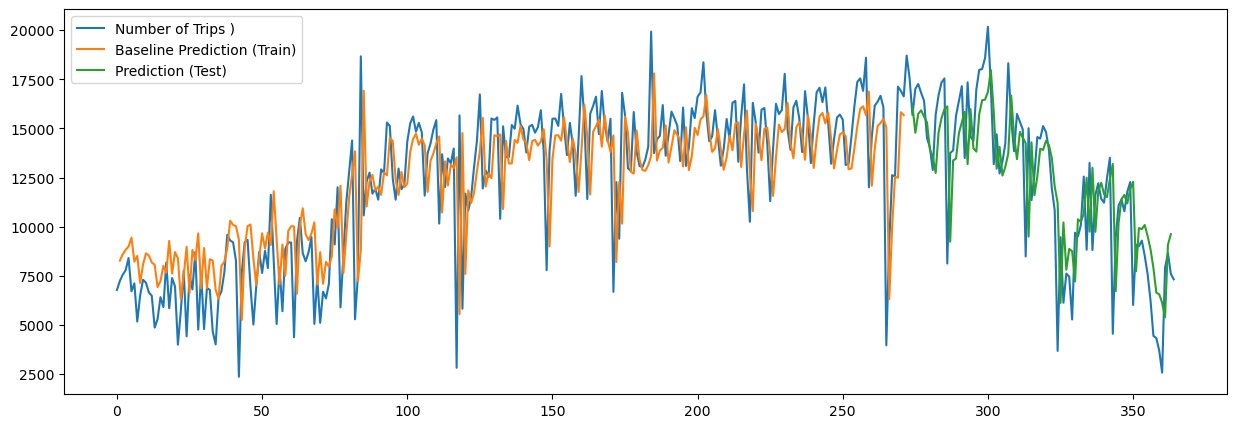

In [162]:
# plot baseline and predictions

plt.figure(figsize=(15, 5))
plt.plot(scaler.inverse_transform(np_trips))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Number of Trips )', 'Baseline Prediction (Train)', 'Prediction (Test)'], loc='upper left')
plt.show()

# MODEL 02   - LSTM Hyperparameter


In [163]:


from keras.regularizers import L2
model2 = Sequential()
model2.add(LSTM(128, return_sequences=True, input_shape=(1, look_back)))  # Look_back set to 365
model2.add(LSTM(units=64, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)))
#model2.add(Dropout(0.2))  # Uncomment and adjust dropout rate
model2.add(LSTM(32))
#model2.add(Dropout(0.2))
model2.add(Dense(16))  # Added a dense layer
model2.add(Dense(1, activation='relu'))
model2.compile(loss='MSLE', optimizer='RMSprop')
model2.summary()


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                  │ (None, 1, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,929 (503.63 KB)

 Trainable params: 128,929 (503.63 KB)

 Non-trainable params: 0 (0.00 B)

In [164]:

# scaler to normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

#call the function processing
trainX, testX , trainY , testY, np_trips = preprocessing(scaler, look_back)

model2.fit(trainX, trainY, epochs=300, validation_data=(testX,testY), batch_size=16, verbose=1)

Epoch 1/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 1.6051 - val_loss: 1.0239
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9114 - val_loss: 0.6143
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5429 - val_loss: 0.3620
Epoch 4/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3133 - val_loss: 0.2011
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1689 - val_loss: 0.1055
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0864 - val_loss: 0.0556
Epoch 7/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0454 - val_loss: 0.0355
Epoch 8/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0304 - val_loss: 0.0288
Epoch 9/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0256 - val_loss: 0.0263
Epoch 10/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0234 - val_loss: 0.0263
Epoch 11/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0230 - val_loss: 0.0261
Epoch 12/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

In [165]:
# make predictions
trainPredict = model2.predict(trainX)
testPredict = model2.predict(testX)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [166]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [167]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 2822.42 RMSE
Test Score: 2842.10 RMSE


In [168]:
# shift train trainPredictPlot for plotting
trainPredictPlot = np.empty_like(np_trips)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict


# shift test testPredictPlot for plotting
testPredictPlot = np.empty_like(np_trips)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(np_trips)-1, :] = testPredict


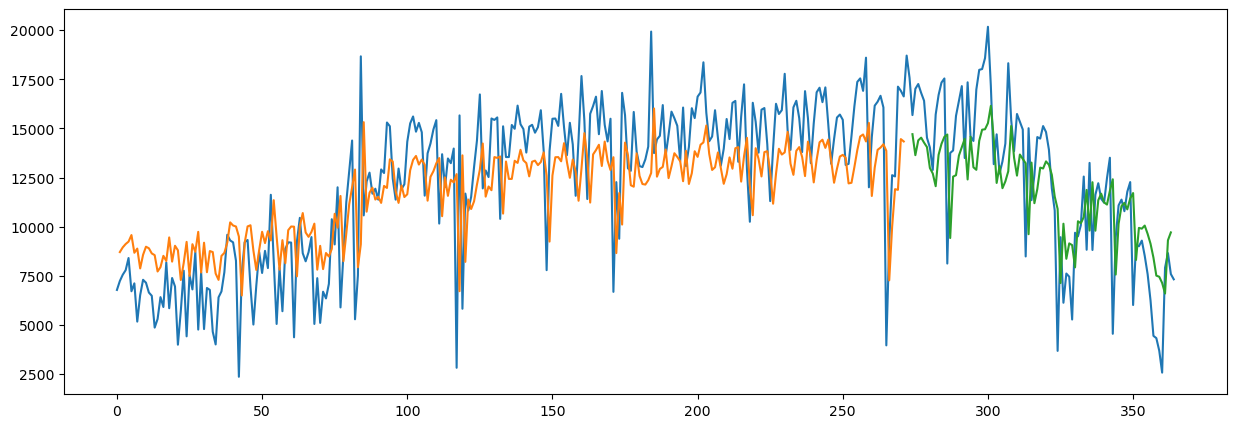

In [169]:
# plot baseline and predictions
plt.figure(figsize=(15, 5))

plt.plot(scaler.inverse_transform(np_trips))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Model 03 - GRU


In [170]:
# Define the GRU model
model3 = keras.Sequential()
model3.add(GRU(128, return_sequences=True, input_shape=(1, look_back)))  # Look_back set to 365
model3.add(GRU(units=64, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)))
model3.add(Dropout(0.2))  # Uncomment and adjust dropout rate
model3.add(GRU(32))
model3.add(Dropout(0.2))
model3.add(Dense(16))  # Added a dense layer
model3.add(Dense(1))
model3.compile(loss='mean_squared_logarithmic_error', optimizer='adam')
model3.summary()


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_9 (GRU)                     │ (None, 1, 128)         │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_10 (GRU)                    │ (None, 1, 64)          │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,505 (380.88 KB)

 Trainable params: 97,505 (380.88 KB)

 Non-trainable params: 0 (0.00 B)

In [171]:
# scaler to normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

#call the function processing
trainX, testX , trainY , testY, np_trips = preprocessing(scaler, look_back)


model3.fit(trainX, trainY, epochs=300, validation_data=(testX,testY), batch_size=16, verbose=1)

Epoch 1/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 1.5491 - val_loss: 1.0733
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9718 - val_loss: 0.7072
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6371 - val_loss: 0.4596
Epoch 4/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4120 - val_loss: 0.2970
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2636 - val_loss: 0.1903
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1709 - val_loss: 0.1237
Epoch 7/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1111 - val_loss: 0.0806
Epoch 8/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0709 - val_loss: 0.0547
Epoch 9/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0480 - val_loss: 0.0387
Epoch 10/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0331 - val_loss: 0.0289
Epoch 11/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0270 - val_loss: 0.0226
Epoch 12/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

In [172]:

# make predictions
trainPredict = model2.predict(trainX)
testPredict = model2.predict(testX)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [173]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [174]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2822.42 RMSE
Test Score: 2842.10 RMSE


In [175]:
# shift train trainPredictPlot for plotting
trainPredictPlot = np.empty_like(np_trips)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict


# shift test testPredictPlot for plotting
testPredictPlot = np.empty_like(np_trips)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(np_trips)-1, :] = testPredict

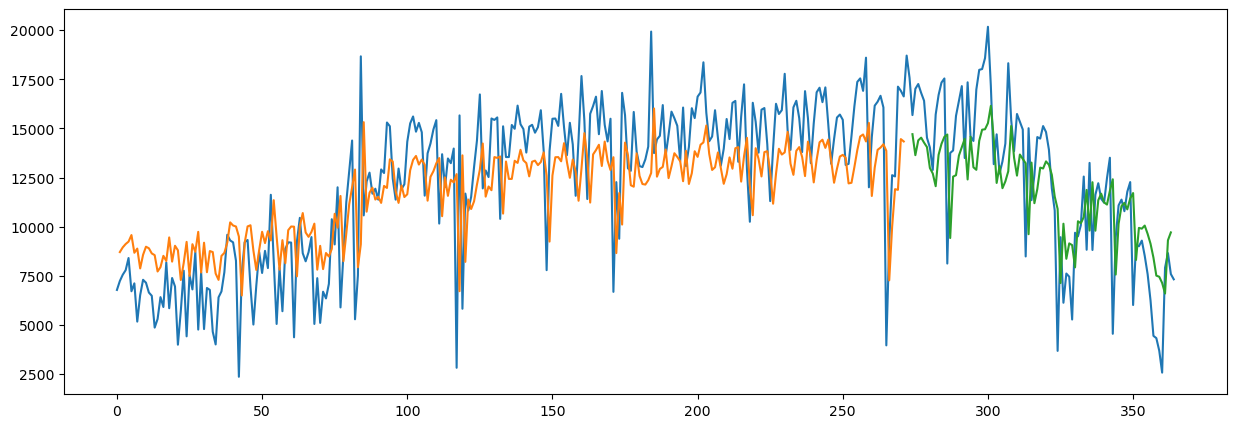

In [176]:
# plot baseline and predictions
plt.figure(figsize=(15, 5))

plt.plot(scaler.inverse_transform(np_trips))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()